# Librares

In [91]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydot
import kymatio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from termcolor import colored
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.figure_factory as ff
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from kymatio import Scattering1D
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [92]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
#import tensorflow_io as tfio

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [93]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

# CallBacks

In [94]:
epochs = 20

model_file_path = "best_model_file.hdf5"
checkpoint = ModelCheckpoint(model_file_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,  # <-- Corrected value
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = tf.keras.callbacks.CSVLogger('Model.log')

# Define a learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.000001,
    power=0.5,
    cycle=False
)


callbacks = [earlystop, csv_logger, reduce_lr, checkpoint]

# Dataset

In [95]:
os.listdir(r'D:\MIET_HeartSound\Dataset\Dataset2\heart_sound')
data = os.path.join(r'D:\MIET_HeartSound\Dataset\Dataset2\heart_sound')
data

'D:\\MIET_HeartSound\\Dataset\\Dataset2\\heart_sound'

In [96]:
train_dir_path = os.path.join(data, 'train')
valid_dir_path = os.path.join(data, 'val')

In [97]:
healthy = os.path.join(train_dir_path, 'healthy', 'a0007.wav')
unhealthy = os.path.join(train_dir_path, 'unhealthy', 'a0002.wav')

In [98]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = wav[:10000]
    print(wav, sample_rate)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    print(wav, sample_rate)
    
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

tf.Tensor(
[[0.04437256]
 [0.09277344]
 [0.08206177]
 ...
 [0.03140259]
 [0.02954102]
 [0.027771  ]], shape=(10000, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor([0.04437256 0.09277344 0.08206177 ... 0.03140259 0.02954102 0.027771  ], shape=(10000,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(
[[ 9.0637207e-03]
 [ 2.2216797e-02]
 [ 2.3773193e-02]
 ...
 [-1.2207031e-04]
 [-1.0986328e-03]
 [ 3.0517578e-05]], shape=(10000, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[ 9.0637207e-03  2.2216797e-02  2.3773193e-02 ... -1.2207031e-04
 -1.0986328e-03  3.0517578e-05], shape=(10000,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)


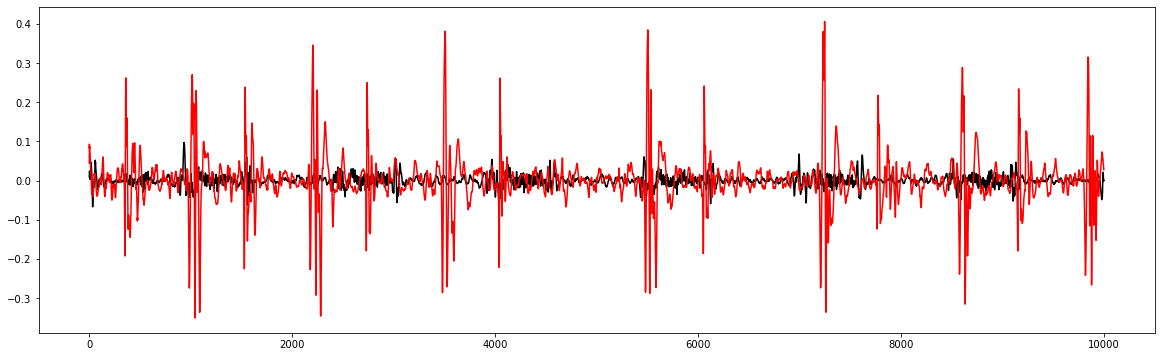

In [99]:
wave = load_wav_16k_mono(healthy)
nwave = load_wav_16k_mono(unhealthy)

plt.figure(figsize=(20, 6))
plt.plot(nwave, color='black')
plt.plot(wave, color='red')
plt.show()

In [100]:
healthy_heart_train = tf.data.Dataset.list_files(train_dir_path+'/healthy'+'/*.wav')
unhealthy_heart_train = tf.data.Dataset.list_files(train_dir_path+'/unhealthy'+'/*.wav')
#healthy_heart_valid = tf.data.Dataset.list_files(valid_dir_path+'/healthy'+'/*.wav')
#unhealthy_heart_valid = tf.data.Dataset.list_files(valid_dir_path+'/unhealthy'+'/*.wav')

In [101]:
hhl_train = tf.data.Dataset.zip((healthy_heart_train, tf.data.Dataset.from_tensor_slices(tf.ones(len(healthy_heart_train)))))
uhl_train = tf.data.Dataset.zip((unhealthy_heart_train, tf.data.Dataset.from_tensor_slices(tf.zeros(len(unhealthy_heart_train)))))
train_data = hhl_train.concatenate(uhl_train)

#hhl_valid = tf.data.Dataset.zip((healthy_heart_valid, tf.data.Dataset.from_tensor_slices(tf.ones(len(healthy_heart_valid)))))
#uhl_valid = tf.data.Dataset.zip((unhealthy_heart_valid, tf.data.Dataset.from_tensor_slices(tf.zeros(len(unhealthy_heart_valid)))))
#valid_data = hhl_valid.concatenate(uhl_valid)

In [102]:
#train_data = train_data.concatenate(valid_data)
lengths = []
for f in os.listdir(os.path.join(train_dir_path, 'healthy')):
    tensor_wave = load_wav_16k_mono(os.path.join(train_dir_path, 'healthy', f))
    lengths.append(len(tensor_wave))

tf.Tensor(
[[0.04437256]
 [0.09277344]
 [0.08206177]
 ...
 [0.03140259]
 [0.02954102]
 [0.027771  ]], shape=(10000, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor([0.04437256 0.09277344 0.08206177 ... 0.03140259 0.02954102 0.027771  ], shape=(10000,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(
[[-0.00408936]
 [-0.00686646]
 [-0.00848389]
 ...
 [ 0.02209473]
 [ 0.02044678]
 [ 0.01861572]], shape=(10000, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[-0.00408936 -0.00686646 -0.00848389 ...  0.02209473  0.02044678
  0.01861572], shape=(10000,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(
[[-0.00057983]
 [-0.00134277]
 [-0.0012207 ]
 ...
 [ 0.11795044]
 [ 0.12466431]
 [ 0.12033081]], shape=(10000, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[-0.00057983 -0.00134277 -0.0012207  ...  0.11795044  0.12466431
  0.12033081], shape=(10000,), dtype=float32) tf.Tensor(2000, shape=(), dtyp

In [103]:
# Calculate the lengths
train_length = tf.data.experimental.cardinality(train_data).numpy()
#valid_length = tf.data.experimental.cardinality(valid_data).numpy()

# Print the lengths
print("Length of train_data:", train_length)
#print("Length of valid_data:", valid_length)

Length of train_data: 3240


In [104]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:10000]
    wav = wav / tf.reduce_max(tf.abs(wav))
    zero_padding = tf.zeros([10000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=80, frame_step=40)
    print('Spectrogram Shape: ', spectrogram.shape,type(spectrogram))
    spectrogram = tf.abs(spectrogram)
    print('Spectrogram Shape: ', spectrogram.shape)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    print('Spectrogram Shape: ', spectrogram.shape,type(spectrogram))
    return spectrogram, label


In [105]:
J = 6
Q = 1
T = 30000
scatt = Scattering1D(J, T, Q)
def extract_WST(file_path, label, wav_length=30000):
    def scattering_transform(wav):
        # Ensure wav is a numpy array
        wav = wav.numpy()
        
        meta = scatt.meta()
        order0 = np.where(meta['order'] == 0)
        order1 = np.where(meta['order'] == 1)
        order2 = np.where(meta['order'] == 2)

        Sx = scatt(wav) 
        return Sx[order1]

    wav = load_wav_16k_mono(file_path)
    wav = tf.cast(wav, dtype=tf.float32)  # Ensure wav is float32
    wav = wav / tf.reduce_max(tf.abs(wav))
    wav = wav[:wav_length] if tf.shape(wav)[0] > wav_length else tf.pad(wav, [(0, wav_length - tf.shape(wav)[0])], "CONSTANT")

    # Using tf.py_function to wrap the scattering transform
    scattering_transform = tf.py_function(scattering_transform, [wav], tf.float32)
    scattering_transform = tf.abs(scattering_transform)
    # You might need to set the shape of the output manually if required
    scattering_transform.set_shape((7, 469))  # Set the correct shape based on your scattering output
    scattering_transform = tf.expand_dims(scattering_transform, axis=2)
    print('scattering_transform',scattering_transform.shape, type(scattering_transform))
    return scattering_transform, label

In [106]:
iterator = hhl_train.shuffle(buffer_size=10000).as_numpy_iterator()
iterator.next()
filepath, label = next(iterator)
print(filepath, label)

b'D:\\MIET_HeartSound\\Dataset\\Dataset2\\heart_sound\\train\\healthy\\b0375.wav' 1.0


In [107]:
spectrogram, label = preprocess(filepath, label)
scattering_coeff, label = extract_WST(filepath, label)
print(scattering_coeff)
print(spectrogram)

tf.Tensor(
[[ 0.00015259]
 [ 0.00177002]
 [ 0.00012207]
 ...
 [-0.11462402]
 [-0.11306763]
 [-0.11050415]], shape=(10000, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[ 0.00015259  0.00177002  0.00012207 ... -0.11462402 -0.11306763
 -0.11050415], shape=(10000,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
Spectrogram Shape:  (249, 65) <class 'tensorflow.python.framework.ops.EagerTensor'>
Spectrogram Shape:  (249, 65)
Spectrogram Shape:  (249, 65, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 0.00015259]
 [ 0.00177002]
 [ 0.00012207]
 ...
 [-0.11462402]
 [-0.11306763]
 [-0.11050415]], shape=(10000, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[ 0.00015259  0.00177002  0.00012207 ... -0.11462402 -0.11306763
 -0.11050415], shape=(10000,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
scattering_transform (7, 469, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[[9.1019797e-04]
 

In [108]:
train_data = train_data.map(preprocess)
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(4)
train_data = train_data.prefetch(2)

Tensor("strided_slice:0", shape=(None, 1), dtype=float32) Tensor("DecodeWav:1", shape=(), dtype=int32)
Tensor("Squeeze:0", shape=(None,), dtype=float32) Tensor("Cast:0", shape=(), dtype=int64)
Spectrogram Shape:  (None, 65) <class 'tensorflow.python.framework.ops.Tensor'>
Spectrogram Shape:  (None, 65)
Spectrogram Shape:  (None, 65, 1) <class 'tensorflow.python.framework.ops.Tensor'>


In [109]:
num_samples = tf.data.experimental.cardinality(train_data).numpy()
print(f"Number of samples in train_data: {num_samples}")

Number of samples in train_data: 810


In [110]:
import tensorflow as tf

# Assuming train_data is your complete dataset
total_samples = len(list(train_data.as_numpy_iterator()))  # Get the total number of samples in the dataset

# Define split proportions
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.20)
test_size = total_samples - train_size - val_size  # Ensures all data is used and accounts for rounding

# Create the datasets
train = train_data.take(train_size)
val = train_data.skip(train_size).take(val_size)
test = train_data.skip(train_size + val_size)

# Example of extracting a batch from the train dataset to check shapes
samples, labels = next(iter(train.batch(1)))
print("Sample shape:", samples.shape)
print("Labels:", labels)

# This gives you three datasets: train, val, and test
# You can iterate over these datasets as needed for training and evaluation


Sample shape: (1, 4, 249, 65, 1)
Labels: tf.Tensor([[1. 1. 1. 1.]], shape=(1, 4), dtype=float32)


In [112]:
# Calculate the lengths
train_length = tf.data.experimental.cardinality(train).numpy()
val_length = tf.data.experimental.cardinality(val).numpy()
test_length = tf.data.experimental.cardinality(test).numpy()

# Print the lengths
print("Length of train:", train_length)
print("Length of val:", val_length)
print("Length of test:", test_length)

Length of train: 567
Length of val: 162
Length of test: 81


# Model

# CNN

In [22]:
def cnn():
    model = Sequential()
    model.add(Conv2D(16, (2,2), activation='relu', input_shape=(249, 65, 1)))
    model.add(Conv2D(32, (2,2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [23]:
# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model0 = cnn()
model0.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 64, 16)       80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 63, 32)       2080      
_________________________________________________________________
flatten (Flatten)            (None, 497952)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               63737984  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 63,740,273
Trainable params: 63,740,273
Non-trainable params: 0
_________________________________________________________________


In [24]:
batch_size = 16

history0 = model0.fit(train, 
                    batch_size=batch_size, 
                    epochs=50,
                    validation_data=test,
                    verbose=1,
                    )

Epoch 1/50
567/567 [==============================] - 11s 11ms/step - loss: 0.1640 - accuracy: 0.9255 - val_loss: 0.5879 - val_accuracy: 0.7757
Epoch 2/50
567/567 [==============================] - 6s 11ms/step - loss: 0.1469 - accuracy: 0.9334 - val_loss: 0.5293 - val_accuracy: 0.7068
Epoch 3/50
567/567 [==============================] - 6s 11ms/step - loss: 0.1323 - accuracy: 0.9418 - val_loss: 0.5349 - val_accuracy: 0.7963
Epoch 4/50
567/567 [==============================] - 6s 11ms/step - loss: 0.1327 - accuracy: 0.9374 - val_loss: 0.5134 - val_accuracy: 0.8004
Epoch 5/50
567/567 [==============================] - 6s 11ms/step - loss: 0.1326 - accuracy: 0.9475 - val_loss: 0.4953 - val_accuracy: 0.7901
Epoch 6/50
567/567 [==============================] - 6s 11ms/step - loss: 0.1152 - accuracy: 0.9475 - val_loss: 0.4951 - val_accuracy: 0.8549
Epoch 7/50
567/567 [==============================] - 6s 11ms/step - loss: 0.1146 - accuracy: 0.9480 - val_loss: 0.4853 - val_accuracy: 0.833

In [25]:
model0.save("Model-cnn-dummy.h5")
print('Model save to Disk')

Model save to Disk


In [26]:
df = pd.DataFrame(history0.history) 
#df.to_excel("output.xlsx")
#df.to_csv("output.csv")
df.head(50)

,loss,accuracy,val_loss,val_accuracy
0,0.163992,0.925485,0.587892,0.775720
1,0.146931,0.933421,0.529342,0.706790
2,0.132279,0.941799,0.534866,0.796296
3,0.132651,0.937390,0.513431,0.800412
4,0.132600,0.947531,0.495311,0.790123
5,0.115156,0.947531,0.495092,0.854938
6,0.114623,0.947972,0.485253,0.833333
7,0.115079,0.958554,0.485286,0.824074
8,0.102266,0.960317,0.453668,0.870370
9,0.101956,0.962963,0.450581,0.878601


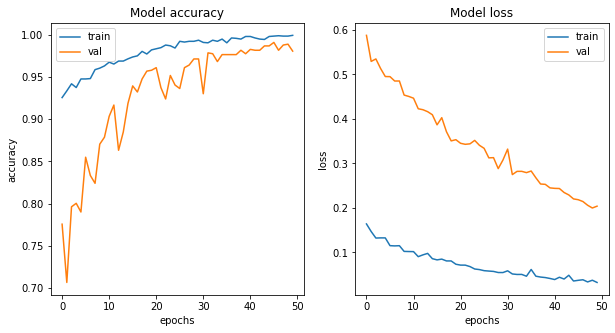

In [27]:
# Interpreting the Metrics
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss' ]):
    ax[i].plot(history0.history[met])
    ax[i].plot(history0.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model0-Results.png")

In [38]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results0 = model0.evaluate(test)
print("test loss, test acc:", results0)

Evaluate on test data
243/243 [==============================] - 1s 3ms/step - loss: 0.2081 - accuracy: 0.9815
test loss, test acc: [0.20805002748966217, 0.9814814925193787]
Wall time: 887 ms


              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       478
         1.0       0.97      1.00      0.98       494

    accuracy                           0.98       972
   macro avg       0.98      0.98      0.98       972
weighted avg       0.98      0.98      0.98       972

[[461  17]
 [  1 493]]


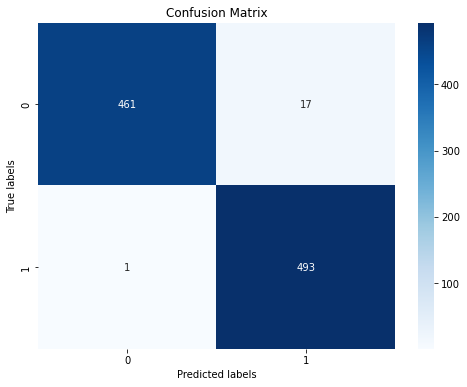

In [40]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Make predictions and evaluate on the test set
true_labels = []
predicted_labels = []

for samples, labels in test.as_numpy_iterator():
    predictions = model0.predict(samples)
    predicted_classes = (predictions > 0.5).astype(int)  # Adjust threshold as needed
    true_labels.extend(labels)
    predicted_labels.extend(predicted_classes)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 5: Classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


BiLSTM

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model architecture
model2 = models.Sequential([
    # Since the input includes a singleton dimension, you can use a Lambda layer to remove it
    layers.Lambda(lambda x: tf.squeeze(x, axis=-1), input_shape=(249, 65, 1)),
    # First BiLSTM layer, return sequences to pass to another LSTM layer
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    # Second BiLSTM layer, no need to return sequences as this is the final LSTM layer
    layers.Bidirectional(layers.LSTM(32)),
    # Dense layer for interpretation
    layers.Dense(64, activation='relu'),
    # Dropout for regularization
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation='sigmoid')
])
 

In [45]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
history2 = model2.fit(train_data, epochs=50, verbose=1, validation_data=val, batch_size=16)

Epoch 1/50
810/810 [==============================] - 52s 59ms/step - loss: 0.3198 - accuracy: 0.8377 - val_loss: 0.6596 - val_accuracy: 0.5772
Epoch 2/50
810/810 [==============================] - 48s 59ms/step - loss: 0.2846 - accuracy: 0.8793 - val_loss: 0.5554 - val_accuracy: 0.7531
Epoch 3/50
810/810 [==============================] - 45s 56ms/step - loss: 0.2536 - accuracy: 0.8938 - val_loss: 0.3586 - val_accuracy: 0.8467
Epoch 4/50
810/810 [==============================] - 43s 53ms/step - loss: 0.2205 - accuracy: 0.9077 - val_loss: 0.4155 - val_accuracy: 0.8014
Epoch 5/50
810/810 [==============================] - 45s 55ms/step - loss: 0.1944 - accuracy: 0.9210 - val_loss: 0.3350 - val_accuracy: 0.8529
Epoch 6/50
810/810 [==============================] - 46s 57ms/step - loss: 0.1900 - accuracy: 0.9207 - val_loss: 0.3232 - val_accuracy: 0.8508
Epoch 7/50
810/810 [==============================] - 50s 61ms/step - loss: 0.1811 - accuracy: 0.9265 - val_loss: 0.3458 - val_accuracy:

In [47]:
model2.save("Model-bilstm-dummy.h5")
print('Model save to Disk')

Model save to Disk


In [48]:
df = pd.DataFrame(history2.history) 
#df.to_excel("output.xlsx")
#df.to_csv("output.csv")
df.head(50)

,loss,accuracy,val_loss,val_accuracy
0,0.319782,0.837654,0.659606,0.577160
1,0.284606,0.879321,0.555371,0.753086
2,0.253560,0.893827,0.358635,0.846708
3,0.220500,0.907716,0.415459,0.801440
4,0.194436,0.920988,0.334977,0.852881
5,0.189964,0.920679,0.323222,0.850823
6,0.181056,0.926543,0.345837,0.849794
7,0.192128,0.919753,0.340582,0.839506
8,0.195371,0.913889,0.346404,0.830247
9,0.194985,0.912963,0.366207,0.830247


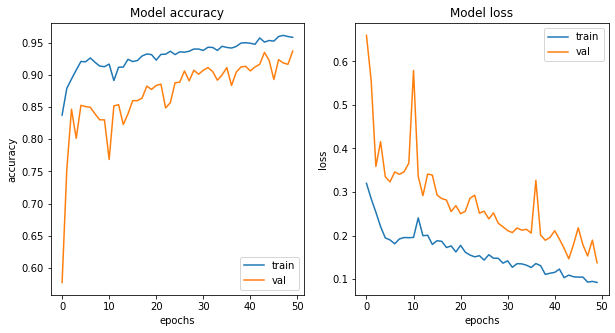

In [49]:
# Interpreting the Metrics
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss' ]):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model2-Results.png")

In [50]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results0 = model2.evaluate(test)
print("test loss, test acc:", results0)

Evaluate on test data
243/243 [==============================] - 6s 25ms/step - loss: 0.1203 - accuracy: 0.9506
test loss, test acc: [0.12025844305753708, 0.9506173133850098]
Wall time: 6.02 s


              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93       465
         1.0       0.95      0.92      0.94       507

    accuracy                           0.94       972
   macro avg       0.94      0.94      0.94       972
weighted avg       0.94      0.94      0.94       972

[[443  22]
 [ 41 466]]


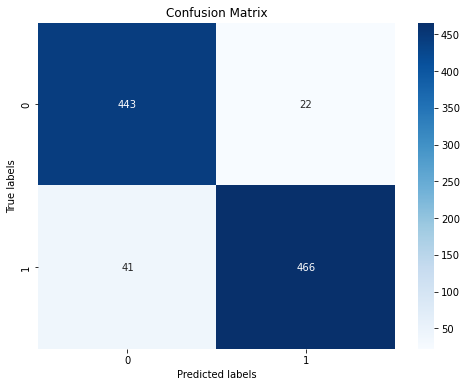

In [51]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Make predictions and evaluate on the test set
true_labels = []
predicted_labels = []

for samples, labels in test.as_numpy_iterator():
    predictions = model2.predict(samples)
    predicted_classes = (predictions > 0.5).astype(int)  # Adjust threshold as needed
    true_labels.extend(labels)
    predicted_labels.extend(predicted_classes)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 5: Classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


BiRNN

In [113]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model architecture
model3 = models.Sequential([
    # Since the input includes a singleton dimension, you can use a Lambda layer to remove it
    layers.Lambda(lambda x: tf.squeeze(x, axis=-1), input_shape=(249, 65, 1)),
    # First BiLSTM layer, return sequences to pass to another LSTM layer
    layers.Bidirectional(layers.SimpleRNN(64, return_sequences=True)),
    # Second BiLSTM layer, no need to return sequences as this is the final LSTM layer
    layers.Bidirectional(layers.SimpleRNN(32)),
    # Dense layer for interpretation
    layers.Dense(64, activation='relu'),
    # Dropout for regularization
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation='sigmoid')
])
 

In [114]:
# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model3.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 249, 65)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 249, 128)          16640     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                10304     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 31,169
Trainable params: 31,169
Non-trainable params: 0
__________________________________________________

In [115]:
history3 = model3.fit(train_data, epochs=30, verbose=1, validation_data=val, batch_size=16)

Epoch 1/30
810/810 [==============================] - 686s 845ms/step - loss: 0.4113 - accuracy: 0.8037 - val_loss: 0.5531 - val_accuracy: 0.7238
Epoch 2/30
810/810 [==============================] - 671s 828ms/step - loss: 0.3256 - accuracy: 0.8651 - val_loss: 0.5039 - val_accuracy: 0.7623
Epoch 3/30
810/810 [==============================] - 678s 837ms/step - loss: 0.2975 - accuracy: 0.8784 - val_loss: 0.4622 - val_accuracy: 0.7793
Epoch 4/30
810/810 [==============================] - 660s 815ms/step - loss: 0.2757 - accuracy: 0.8873 - val_loss: 0.4631 - val_accuracy: 0.7778
Epoch 5/30
810/810 [==============================] - 675s 834ms/step - loss: 0.2591 - accuracy: 0.8954 - val_loss: 0.3926 - val_accuracy: 0.8349
Epoch 6/30
810/810 [==============================] - 664s 819ms/step - loss: 0.2442 - accuracy: 0.9052 - val_loss: 0.3949 - val_accuracy: 0.8318
Epoch 7/30
810/810 [==============================] - 660s 815ms/step - loss: 0.2453 - accuracy: 0.9083 - val_loss: 0.3624 -

KeyboardInterrupt: 

In [ ]:
model3.save("Model-birnn-dummy.h5")
print('Model save to Disk')

Model save to Disk


In [ ]:
df = pd.DataFrame(history3.history) 
#df.to_excel("output.xlsx")
#df.to_csv("output.csv")
df.head(50)

,loss,accuracy,val_loss,val_accuracy
0,0.306371,0.850926,0.496700,0.763375
1,0.284031,0.870062,0.478441,0.763375
2,0.262227,0.881481,0.467883,0.769547
3,0.269840,0.881173,0.493288,0.759259
4,0.259980,0.881790,0.484882,0.775720
5,0.261550,0.888272,0.444263,0.782922
6,0.242534,0.891667,0.429282,0.799383
7,0.256438,0.890741,0.492301,0.762346
8,0.249478,0.888889,0.450501,0.778807
9,0.229170,0.893210,0.489525,0.747942


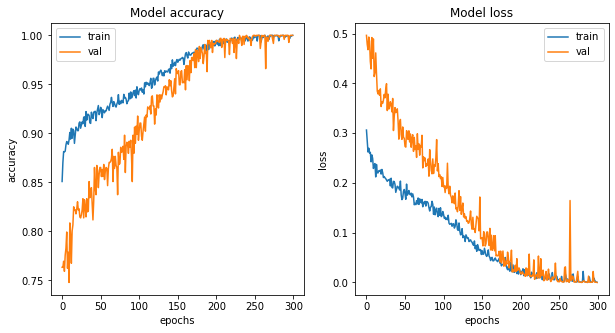

In [ ]:
# Interpreting the Metrics
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss' ]):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model3-Results.png")

In [ ]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results0 = model3.evaluate(test)
print("test loss, test acc:", results0)

Evaluate on test data
243/243 [==============================] - 2s 7ms/step - loss: 4.6119e-04 - accuracy: 1.0000
test loss, test acc: [0.0004611946933437139, 1.0]
Wall time: 1.64 s


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       495
         1.0       1.00      1.00      1.00       477

    accuracy                           1.00       972
   macro avg       1.00      1.00      1.00       972
weighted avg       1.00      1.00      1.00       972

[[495   0]
 [  0 477]]


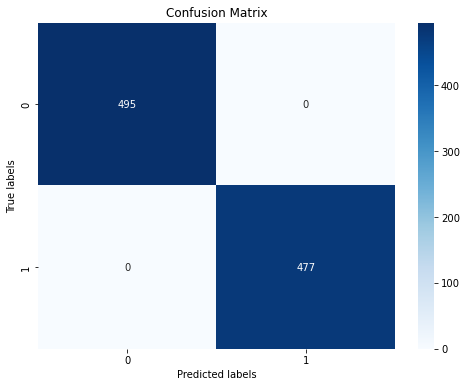

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Make predictions and evaluate on the test set
true_labels = []
predicted_labels = []

for samples, labels in test.as_numpy_iterator():
    predictions = model3.predict(samples)
    predicted_classes = (predictions > 0.5).astype(int)  # Adjust threshold as needed
    true_labels.extend(labels)
    predicted_labels.extend(predicted_classes)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 5: Classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

SVM

In [87]:
import numpy as np

def preprocess_dataset(dataset):
    # Flatten each sample and collect them
    all_samples = []
    all_labels = []

    for samples, labels in dataset.as_numpy_iterator():
        # Flatten from (4, 7, 469, 1) to (4, 7*469)
        samples_flattened = samples.reshape(samples.shape[0], -1)
        all_samples.append(samples_flattened)
        all_labels.append(labels)

    # Convert lists to numpy arrays
    all_samples = np.vstack(all_samples)  # Stack arrays vertically
    all_labels = np.concatenate(all_labels)
    
    return all_samples, all_labels

# Prepare the full dataset into features and labels
X, y = preprocess_dataset(train_data)  # Assuming train_data contains both train and test



In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)


In [89]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# Create an SVM model with a pipeline that includes scaling
model_svm = make_pipeline(
    StandardScaler(),
    svm.SVC(kernel='linear', random_state=84)
)

# Train the model
model_svm.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', random_state=84))])

In [90]:
accuracy = model_svm.score(X_test, y_test)
print(f'Test accuracy: {accuracy}')


Test accuracy: 0.8040123456790124


Accuracy: 0.808641975308642
Precision: 0.8793103448275862
Recall: 0.8826923076923077
F1 Score: 0.8809980806142034


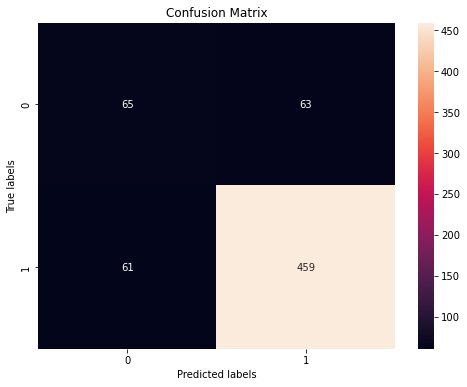

In [73]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Predict with the model
y_pred = model_svm.predict(X_test)

# Calculate metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plotting the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()